In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
from mpl_toolkits.mplot3d import Axes3D

from tqdm import tqdm

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
cloud_data = pd.read_csv("C:/Users/bened/Documents/UNIVERSITY/SchoenStats/PyTorch Working Directory/DreamyDatasets/3D_three_clouds.csv")
cloud_data.info()

# random sample from dataset
# X_data - [1000, 2] training/development data
# t_data - [200, 2] testing/validation data
X = cloud_data.sample(1000).reset_index(drop=True)
X_data = torch.tensor(X.values)
X = cloud_data.sample(200).reset_index(drop=True)
t_data = torch.tensor(X.values)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8000 entries, 0 to 7999
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   x       8000 non-null   float64
 1   y       8000 non-null   float64
 2   z       8000 non-null   float64
dtypes: float64(3)
memory usage: 187.6 KB


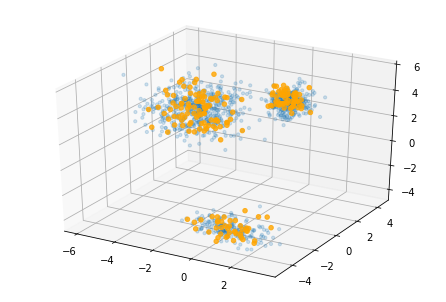

In [3]:
# plot datasets
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(X_data[:,0], X_data[:,1], X_data[:,2], alpha=0.2, s=10)
ax.scatter(t_data[:,0], t_data[:,1], t_data[:,2], alpha=0.8, s=20, color='orange')
plt.show()

In [4]:
# ensure shaping of data
X_data = X_data[:,0:2].view(-1,2)
t_data = t_data[:,0:2].view(-1,2)

In [5]:
n_input = 1
n_output = 1
# initialise model
class MDN(nn.Module):
    def __init__(self, n_hidden, n_gaussians):
        super(MDN, self).__init__()
        
        self.z_h = nn.Sequential(nn.Linear(n_input, n_hidden),nn.Tanh())
        
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
        
        self.z_pi = nn.Linear(n_hidden, n_gaussians)
        self.z_mu = nn.Linear(n_hidden, n_gaussians)
        self.z_sigma = nn.Linear(n_hidden, n_gaussians)
    
    def forward(self, x):
        z_h = self.z_h(x)
        pi = F.softmax(self.z_pi(z_h), -1)
        mu = self.z_mu(z_h)
        sigma = torch.exp(self.z_sigma(z_h))
        return pi, mu, sigma

model = MDN(n_hidden=10, n_gaussians=3)

# define optimiser
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=0.001)

In [6]:
# modification to the error loss function (because it is an MDN)
def mdn_loss_fn(y, mu, sigma, pi):
    m = torch.distributions.Normal(loc=mu, scale=sigma)
    loss = torch.exp(m.log_prob(y))
    loss = torch.sum(loss * pi, dim=1)
    loss = -torch.log(loss)
    return torch.mean(loss)

In [7]:
# training step
num_epoch = 1000
batch_size = 128

model=model.double()
loss_list = []

for epoch in tqdm(range(num_epoch)): 
    permu = torch.randperm(X_data.shape[0])
    
    for i in range(0, X_data.shape[0], batch_size):
        indices = permu[i:i+batch_size]
        batch_x, batch_y = X_data[indices,0], X_data[indices,1]
        pi, mu, sigma = model.forward(batch_x.unsqueeze(1))
        optimizer.zero_grad()
        l = mdn_loss_fn(batch_y.unsqueeze(1), mu, sigma, pi)
        l.backward()
        optimizer.step()

    if epoch % 100 == 0:
        loss_list.append(l.detach())
        
loss_list

100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:13<00:00, 75.95it/s]


[tensor(2.4881, dtype=torch.float64),
 tensor(1.1778, dtype=torch.float64),
 tensor(1.1242, dtype=torch.float64),
 tensor(1.2265, dtype=torch.float64),
 tensor(1.2420, dtype=torch.float64),
 tensor(1.2175, dtype=torch.float64),
 tensor(1.3056, dtype=torch.float64),
 tensor(1.1725, dtype=torch.float64),
 tensor(1.3873, dtype=torch.float64),
 tensor(1.2430, dtype=torch.float64)]

In [8]:
# retrieving estimates for distribution parameters
pi, mu, sigma = model(t_data[:,0].unsqueeze(1))

In [9]:
# sampling from parameter estimates
n_samples = 200
k = torch.multinomial(pi, 1).view(-1)
t_pred = torch.normal(mu, sigma)[np.arange(n_samples), k].data
t_pred = t_pred.view(-1, 1)

In [10]:
full_res = torch.cat((t_data[:,0:2], t_pred, pi, mu, sigma), dim=1).detach().numpy()
full_res = pd.DataFrame(full_res, columns=("X", "T", "T_pred",
                                           "pi_1", "pi_2", "pi_3",
                                           "mu_1", "mu_2", "mu_3",
                                           "sigma_1", "sigma_2", "sigma_3"))
full_res = full_res.sort_values(by='X', axis=0)
full_res['pi'] = ""

In [11]:
for i in tqdm(range(len(full_res))):
    if full_res['pi_1'][i] < full_res['pi_3'][i] and full_res['pi_2'][i] < full_res['pi_3'][i]:
        full_res['pi'][i] = 3
    elif full_res['pi_1'][i] < full_res['pi_2'][i] and full_res['pi_3'][i] < full_res['pi_2'][i]:
        full_res['pi'][i] = 2   
    else:
        full_res['pi'][i] = 1

  0%|                                                                                          | 0/200 [00:00<?, ?it/s]C:\Users\bened\anaconda3\lib\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\bened\anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\bened\anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the docum

In [12]:
full_res

,X,T,T_pred,pi_1,pi_2,pi_3,mu_1,mu_2,mu_3,sigma_1,sigma_2,sigma_3,pi
82,-5.283178,0.712704,1.380449,0.996836,0.002902,0.000262,-0.093421,0.421042,-1.050453,0.891977,1.673008,0.508931,1
24,-5.182376,0.205393,-1.454088,0.996780,0.002943,0.000276,-0.086675,0.479168,-1.119218,0.898059,1.670234,0.496549,1
130,-5.039345,-0.811371,0.861144,0.996697,0.003004,0.000299,-0.076974,0.562837,-1.218144,0.906848,1.666199,0.479274,1
57,-4.866761,-0.857122,0.576898,0.996590,0.003082,0.000328,-0.065090,0.665467,-1.339402,0.917682,1.661173,0.458936,1
193,-4.662167,0.641931,1.533367,0.996451,0.003181,0.000368,-0.050793,0.789147,-1.485398,0.930804,1.654966,0.435617,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
124,2.342816,-4.104349,-3.824546,0.000075,0.015279,0.984647,-0.081372,3.186936,-3.956237,1.923832,0.484516,0.304006,3
132,2.500954,-4.336211,-4.012861,0.000066,0.013475,0.986459,-0.069363,3.178923,-3.926597,1.933291,0.483446,0.305459,3
58,2.556227,-4.120936,-3.296938,0.000063,0.012958,0.986979,-0.065382,3.175991,-3.916452,1.936037,0.483116,0.305944,3
43,2.803325,-3.801548,-4.059396,0.000054,0.011151,0.988795,-0.048978,3.162934,-3.873669,1.945629,0.481838,0.307913,3


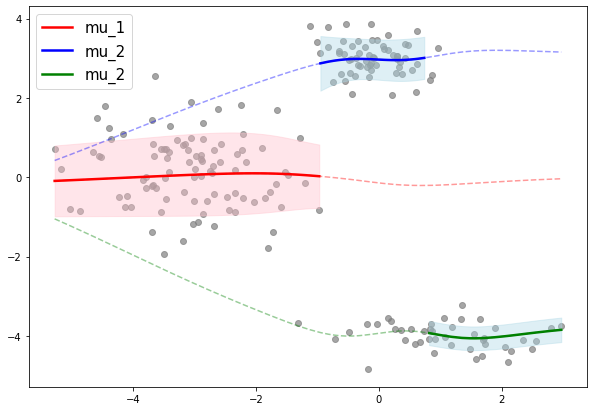

In [13]:
plt.figure(figsize=[10, 7])
plt.scatter(full_res['X'], full_res['T'], alpha=0.7, color='grey')
mod1=full_res[full_res.pi == 1]
mod2=full_res[full_res.pi == 2]
mod3=full_res[full_res.pi == 3]

plt.plot(mod1['X'], mod1['mu_1'], color='red', linewidth=2.5, label='mu_1')
plt.plot(full_res['X'], full_res['mu_1'], '--',color='red', alpha=0.4, linewidth=1.5)
plt.fill_between(mod1['X'],
                 mod1['mu_1']+mod1['sigma_1'],
                 mod1['mu_1']-mod1['sigma_1'],
                 alpha=0.4, color='pink')

plt.plot(mod2['X'], mod2['mu_2'], color='blue', linewidth=2.5, label='mu_2')
plt.plot(full_res['X'], full_res['mu_2'], '--',color='blue', alpha=0.4, linewidth=1.5)
plt.fill_between(mod2['X'],
                 mod2['mu_2']+mod2['sigma_2'],
                 mod2['mu_2']-mod2['sigma_2'],
                 alpha=0.4, color='lightblue')

plt.plot(mod3['X'], mod3['mu_3'], color='green', linewidth=2.5, label='mu_2')
plt.plot(full_res['X'], full_res['mu_3'], '--',color='green', alpha=0.4, linewidth=1.5)
plt.fill_between(mod3['X'],
                 mod3['mu_3']+mod3['sigma_3'],
                 mod3['mu_3']-mod3['sigma_3'],
                 alpha=0.4, color='lightblue')

plt.legend(loc='upper left', prop={'size': 15})

fig = plt.gcf()
fig.savefig("MDN_mu_three_clouds.png")
plt.draw()

plt.show()

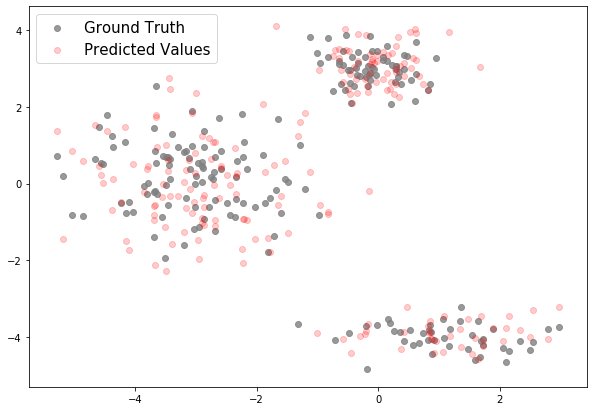

In [14]:
plt.figure(figsize=[10, 7])

plt.scatter(t_data[:,0], t_data[:,1], alpha = 0.8, color = 'grey', label='Ground Truth')
plt.scatter(t_data[:,0], t_pred.detach(), alpha = 0.2, color = 'red', label = 'Predicted Values')
plt.legend(loc='upper left', prop={'size': 15})

fig = plt.gcf()
fig.savefig("MDN_pred_three_clouds.png")
plt.draw()
plt.show()

In [15]:
summary(model.float(), (1, 1))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 1, 10]              20
              Tanh-2                [-1, 1, 10]               0
            Linear-3                 [-1, 1, 3]              33
            Linear-4                 [-1, 1, 3]              33
            Linear-5                 [-1, 1, 3]              33
Total params: 119
Trainable params: 119
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.00
Estimated Total Size (MB): 0.00
----------------------------------------------------------------
